In [1]:
import os
os.chdir("../../../")

import itertools
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy

#!pip install pmdarima
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from pmdarima import model_selection
from pmdarima import auto_arima
from src.tsa.ts_utils import * 
from src.tsa.utsmodel import * 
from src.tsa.mtsmodel import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
folder = os.getcwd() + "/data/tourism/tonga/intermediate/"
filepath = [folder + file for file in os.listdir(folder) if ".csv" in file]

## SARIMAX

,date,yacht,all,total,ship,stringency_index,covid,tonga_flights,tonga_hotel,tonga_travel
0,2010-01-01,4,3808,3158,646,0.0,0.0,1.023708,1.177964,0.530498
1,2010-02-01,5,2384,2379,0,0.0,0.0,0.722348,1.372753,0.725430
2,2010-03-01,5,3992,3134,853,0.0,0.0,0.816930,1.415719,0.367724
3,2010-04-01,30,5650,2818,2802,0.0,0.0,0.595805,1.081875,0.205626
4,2010-05-01,177,9150,3670,5303,0.0,0.0,1.128415,1.849573,0.931053


training size : 144, testing size : 0
THE BENCHMARK EVALUATION FOR TOTAL 

STARTED TO CONDUCT STEPWISE SEARCHING FOR TOTAL 

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  144
Model:             SARIMAX(0, 0, 1)x(2, 0, [], 12)   Log Likelihood                -196.164
Date:                             Tue, 19 Sep 2023   AIC                            406.327
Time:                                     16:19:27   BIC                            427.116
Sample:                                          0   HQIC                           414.774
                                             - 144                                         
Covariance Type:                               opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------

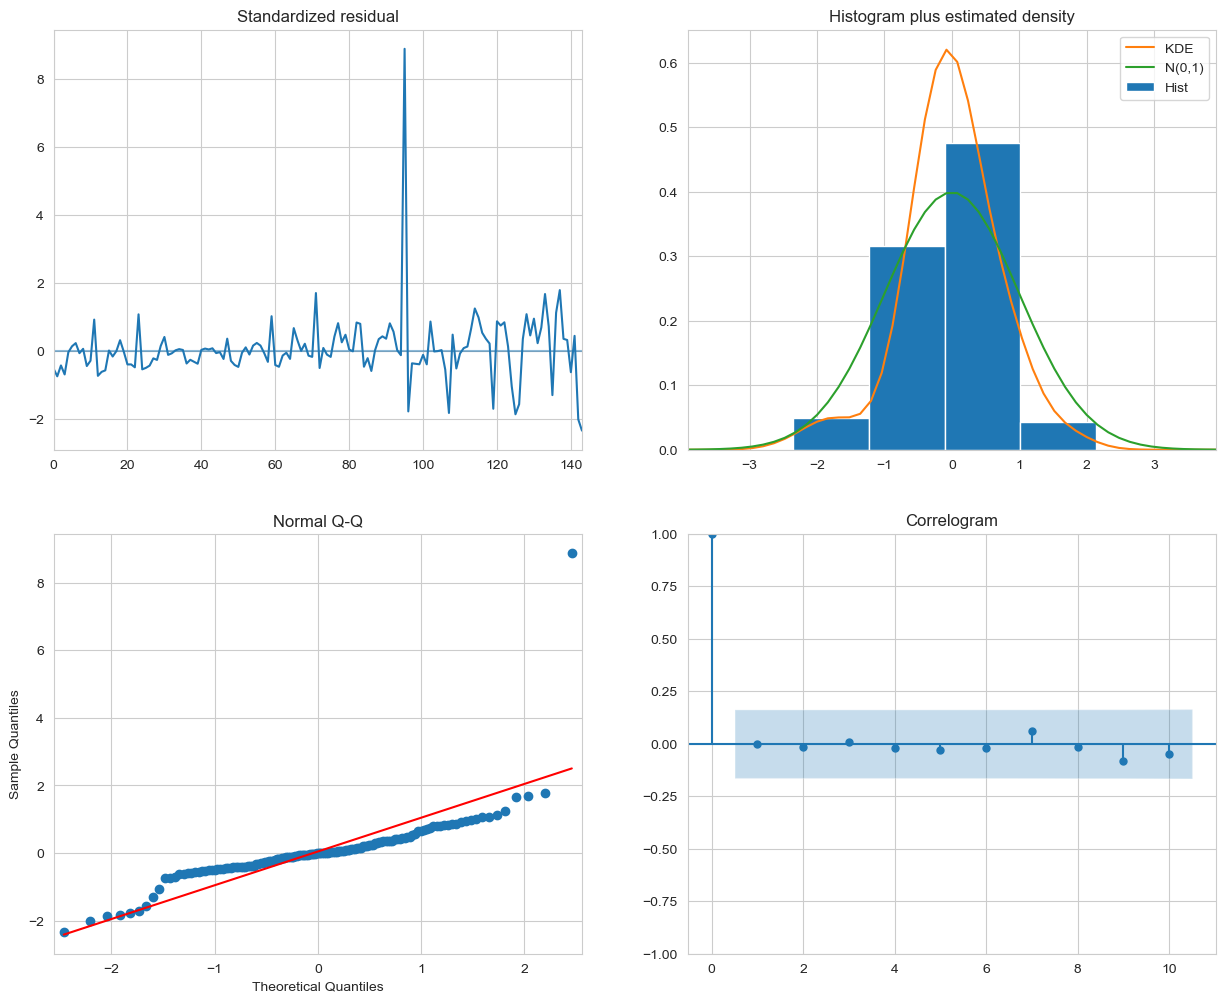

STARTED TO CONDUCT GRID SEARCHING FOR TOTAL 

STARTED TO CONDUCT CROSS-VALIDATION FOR TOTAL 

Best Models from Cross-validation is  ARIMA(0,0,1)(0,1,1)[12] intercept 



In [3]:
from sarimaxs import run_sarimax
tg, best_mod, best_mod_pred = run_sarimax(country="tonga", y_vars=["total"], method="scaledlogit",
                    exog_var=["covid", "stringency_index", "tonga_travel"])

In [5]:
calculate_evaluation(tg["total"], tg["total_pred"])

{'MSE': 682022.1116505942,
 'RMSE': 825.8463002584647,
 'MAE': 554.5386438865157,
 'SMAPE': 30.128564126813846}

## Ratio


TONGA's Official and Avaition Data.

 Create Loaded Factor for TONGA:

 Regression TONGA:
                            OLS Regression Results                            
Dep. Variable:                  ratio   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     91.43
Date:                Wed, 02 Aug 2023   Prob (F-statistic):           1.38e-17
Time:                        16:56:24   Log-Likelihood:                 60.545
No. Observations:                  36   AIC:                            -105.1
Df Residuals:                      28   BIC:                            -92.42
Df Model:                           7                                         
Covariance Type:                  HAC                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------

,date,ratio,total,seats_arrivals_intl,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper,pred_mean
0,2019-01-01,0.297294,4372,14706.0,0.360706,0.048916,0.264832,0.456580,0.222141,0.499271,5304.538109
1,2019-02-01,0.278131,2709,9740.0,0.363154,0.048099,0.268881,0.457428,0.225692,0.500617,3537.124295
2,2019-03-01,0.303732,3109,10236.0,0.369590,0.046598,0.278261,0.460919,0.234129,0.505050,3783.122941
3,2019-04-01,0.394065,4183,10615.0,0.449611,0.027280,0.396142,0.503079,0.336176,0.563045,4772.616311
4,2019-05-01,0.435655,5166,11858.0,0.445547,0.025425,0.395715,0.495380,0.333781,0.557314,5283.301421


,MSE,RMSE,MAE,SMAPE
mean,7.898678e+06,2810.458659,2511.586420,147.552078
naive,1.045461e+06,1022.477747,597.257143,69.556373
ratio,2.050972e+05,452.876617,251.921849,84.342952


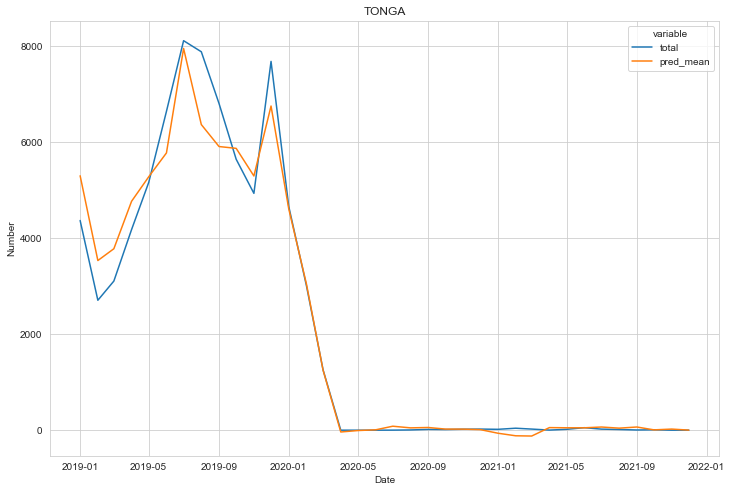

In [4]:
country = "tonga"
mod = RatioPipe(country=country, data=None)
print(f"\n{country.upper()}'s Official and Avaition Data.")
mod.read_and_merge()

print(f"\n Create Loaded Factor for {country.upper()}:")
mod.transform()

optimal_lag = int(4 * (len(mod.data)/100) ** (2/9)) + 1
print(f"\n Regression {country.upper()}:")
mod.fit(formula="ratio~covid * stringency_index+C(quarter)+"+str(country)+"_travel",
        maxlags=optimal_lag)
pred_df = mod.get_prediction_df()

mean_pred, naive_pred = \
    mean_method(pred_df["total"]), naive_method(pred_df["total"])

benchmark = pd.DataFrame()
eval_name = ["mean", "naive", "ratio"]
for idx, pred in zip(eval_name, [mean_pred, naive_pred, pred_df["pred_mean"]]):
    eval_df = pd.DataFrame(calculate_evaluation(
        pred_df["total"], pred), index=[idx])
    benchmark = pd.concat([benchmark, eval_df])
display(benchmark)

ratio_viz_df = pred_df[["date", "total", "pred_mean"]].melt(id_vars="date")
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(data=ratio_viz_df, x="date", y="value", hue="variable")
ax.set(xlabel="Date", ylabel="Number", title=str(country).upper())
plt.show()

In [5]:
gt = mod.read_trends_data()
gt.columns = [col.replace(" ", "_") for col in gt.columns]
tonga_si = mod.read_covid_data()

In [6]:
tonga_si = (tonga_si[tonga_si.date >="2022-01-01"]
                 .dropna()
                 .reset_index().drop("index", axis=1))
temp_fu = (tonga_si.merge(
    gt[["date", "tonga_flights", "tonga_travel"]],
    how="left", on="date"))
temp_fu["covid"] = (temp_fu.date >= "2020-03-12").astype(int)
temp_fu["quarter"] = temp_fu["date"].dt.quarter
temp_fu.columns = [col.replace(" ", "_") for col in temp_fu.columns]
temp_fu = temp_fu.dropna() 

In [11]:
upper = best_mod_pred.total.max()+1
lower = best_mod_pred.total.min()-1

In [12]:
uni_future = (best_mod.get_forecast(
    exog=temp_fu[["covid", "stringency_index", "tonga_travel"]],
    steps=len(temp_fu))
    .summary_frame())
uni_future.columns.name = None
for col_idx, col in enumerate(uni_future.columns):
    for row_idx, _ in enumerate(uni_future[col]):
        uni_future.iloc[row_idx, col_idx] = inverse_scaledlogit(
            uni_future.iloc[row_idx, col_idx], upper, lower)

uni_future = (uni_future.reset_index()
              .drop("index", axis=1))
uni_future.columns = [col.replace("mean", "uni") for col in uni_future.columns]
uni_future["date"] = temp_fu["date"]
uni_future.head(5)

,uni,uni_se,uni_ci_lower,uni_ci_upper,date
0,-0.622606,6918.473717,-0.940004,1.373509,2022-01-01
1,0.987842,6978.217910,-0.702518,12.269954,2022-02-01
2,1.427960,6978.217910,-0.636639,15.203784,2022-03-01
3,1.857113,6978.217910,-0.572398,18.063048,2022-04-01
4,4.573492,6978.217910,-0.165657,36.127667,2022-05-01


In [13]:
future = mod.res.get_prediction(temp_fu).summary_frame()
future["date"] = temp_fu["date"]
future

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper,date
0,0.179035,0.247443,-0.305944,0.664013,-0.316155,0.674224,2022-01-01
1,-0.069137,0.042315,-0.152073,0.013799,-0.199087,0.060812,2022-02-01
2,-0.079364,0.047581,-0.172620,0.013893,-0.216131,0.057403,2022-03-01
3,0.007963,0.010804,-0.013212,0.029138,-0.094296,0.110222,2022-04-01
4,0.049166,0.031746,-0.013056,0.111387,-0.068648,0.166979,2022-05-01
5,0.044848,0.021263,0.003173,0.086523,-0.063527,0.153224,2022-06-01
6,0.089431,0.048012,-0.004671,0.183533,-0.047914,0.226776,2022-07-01
7,0.116232,0.066926,-0.014940,0.247404,-0.048737,0.281200,2022-08-01
8,0.107140,0.059079,-0.008653,0.222933,-0.045885,0.260165,2022-09-01
9,0.068486,0.040371,-0.010640,0.147612,-0.059066,0.196037,2022-10-01


In [14]:
aviation_path = os.getcwd() + "/data/tourism/aviation_seats_flights_pic.xlsx"
aviation = pd.read_excel(aviation_path)

tg_avi = (aviation[(aviation.ISO == "TO") & (aviation.Aircraft_type == "passenger")]
          .reset_index()
          .drop("index", axis=1)
          [["Date", "Seats_arrivals_intl", "Seats_arrivals_total"]])
tg_avi["Date"] = pd.to_datetime(tg_avi["Date"])
tg_avi["Month"], tg_avi["Year"] = tg_avi["Date"].dt.month, tg_avi["Date"].dt.year
tg_avi = tg_avi.groupby(["Year", "Month"]).sum().reset_index()
tg_avi["date"] = [str(y) + "-" + str(m)
                  for y, m in zip(tg_avi.Year, tg_avi.Month)]
tg_avi["date"] = pd.to_datetime(tg_avi["date"])
tg_avi_future = tg_avi[tg_avi.date >= "2022-01-01"].reset_index().drop("index", axis=1)
tg_avi_future.head(5)

,Year,Month,Seats_arrivals_intl,Seats_arrivals_total,date
0,2022,1,1093,1093,2022-01-01
1,2022,2,1525,1525,2022-02-01
2,2022,3,2410,2410,2022-03-01
3,2022,4,1726,1726,2022-04-01
4,2022,5,1464,1464,2022-05-01


In [15]:
future_colnames = [col for col in future.columns if col.startswith('mean')]
for col in future_colnames:
    if "se" in col:
        pass
    else:
        colname = col.replace("mean", "lf")
        future[colname] = tg_avi_future["Seats_arrivals_intl"] * future[col]
future.head(5)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper,date,lf,lf_ci_lower,lf_ci_upper
0,0.179035,0.247443,-0.305944,0.664013,-0.316155,0.674224,2022-01-01,195.684914,-334.396912,725.766739
1,-0.069137,0.042315,-0.152073,0.013799,-0.199087,0.060812,2022-02-01,-105.434155,-231.911666,21.043357
2,-0.079364,0.047581,-0.172620,0.013893,-0.216131,0.057403,2022-03-01,-191.266496,-416.014109,33.481116
3,0.007963,0.010804,-0.013212,0.029138,-0.094296,0.110222,2022-04-01,13.744386,-22.804114,50.292886
4,0.049166,0.031746,-0.013056,0.111387,-0.068648,0.166979,2022-05-01,71.978543,-19.114009,163.071096


In [16]:
forecast = future.iloc[:, -4:]
forecast = forecast.merge(uni_future)
forecast

,date,lf,lf_ci_lower,lf_ci_upper,uni,uni_se,uni_ci_lower,uni_ci_upper
0,2022-01-01,195.684914,-334.396912,725.766739,-0.622606,6918.473717,-0.940004,1.373509
1,2022-02-01,-105.434155,-231.911666,21.043357,0.987842,6978.217910,-0.702518,12.269954
2,2022-03-01,-191.266496,-416.014109,33.481116,1.427960,6978.217910,-0.636639,15.203784
3,2022-04-01,13.744386,-22.804114,50.292886,1.857113,6978.217910,-0.572398,18.063048
4,2022-05-01,71.978543,-19.114009,163.071096,4.573492,6978.217910,-0.165657,36.127667
5,2022-06-01,100.953403,7.143547,194.763259,13.521545,6978.217910,1.175571,95.228210
6,2022-07-01,259.886947,-13.573162,533.347056,27.033255,6978.217910,3.204878,183.306991
7,2022-08-01,575.347577,-73.955229,1224.650384,23.245475,6978.217910,2.635506,158.755333
8,2022-09-01,645.089841,-52.101505,1342.281188,20.981444,6978.217910,2.295364,144.028564
9,2022-10-01,238.056865,-36.985065,513.098794,23.697075,6978.217910,2.703370,161.688202


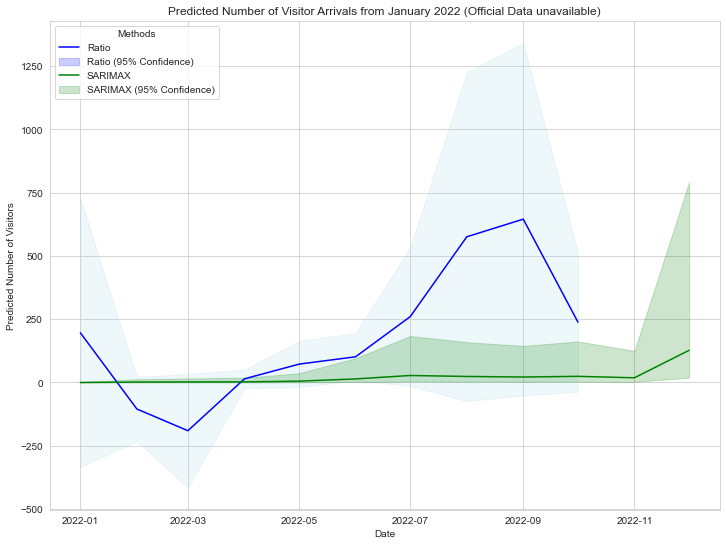

In [22]:
fig, ax = plt.subplots(figsize=(12, 9))
sns.set_style("whitegrid")
sns.lineplot(data=forecast, x="date", y="lf", color="blue", )
sns.lineplot(data=forecast, x="date", y="uni",  color="green")
ax.fill_between(data=forecast, x="date", y1="lf_ci_lower",
                y2="lf_ci_upper", alpha=0.2, color="lightblue")
ax.fill_between(data=forecast, x="date", y1="uni_ci_lower",
                y2="uni_ci_upper", alpha=0.2, color="green")
plt.legend(title='Methods', loc='upper left', 
           labels=['Ratio', 'Ratio (95% Confidence)', 'SARIMAX', 'SARIMAX (95% Confidence)'])
plt.xlabel("Date")
plt.ylabel("Predicted Number of Visitors")
plt.title("Predicted Number of Visitor Arrivals from January 2022 (Official Data unavailable)")
plt.show()
fig.savefig(os.getcwd()+"/tonga_predicition.png", dpi=400)